## Basic Chatbot

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_groq import ChatGroq
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages

In [2]:
import os
GROK_API_KEY = os.getenv("GROK_API_KEY")

In [3]:
model = ChatGroq(api_key=GROK_API_KEY, model="llama-3.1-8b-instant")

In [4]:
class ChatState(TypedDict):
    
    messages: Annotated[list[BaseMessage], add_messages]

In [5]:
def chat_response(state: ChatState) :

    messages = state["messages"]
    response = model.invoke(messages)

    return {"messages": [response]}

    

In [6]:
graph = StateGraph(ChatState)

In [7]:
graph.add_node('chat_response', chat_response)
graph.add_edge(START, 'chat_response')
graph.add_edge('chat_response', END)

In [8]:
workflow = graph.compile()

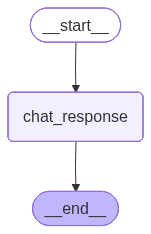

In [9]:
workflow

In [10]:
initial_state = {'messages': [HumanMessage(content="Hello, how are you?")]}
result = workflow.invoke(initial_state)
result['messages'][-1].content  #to print exact message by the model

"I'm functioning properly, thank you for asking. How can I assist you today?"

In [14]:
while True:

    user_input = input("You: ")
    print("User:", user_input)
    if user_input.strip().lower() in ['exit', 'quit']:
        print("Exiting chat.")
        break

    initial_state = {'messages': [HumanMessage(content=user_input)]}
    result = workflow.invoke(initial_state)
    print("Bot:", result['messages'][-1].content)

User: hi
Bot: How can I assist you today?
User: cookie
Bot: Cookies are a classic favorite for many people around the world. Here are some fun facts and types of cookies:

1. **History of Cookies**: Cookies have been around for thousands of years, with evidence of cookie-like treats dating back to ancient civilizations such as the Egyptians, Greeks, and Romans.
2. **Types of Cookies**: There are countless types of cookies, including:
	* Chocolate chip cookies
	* Peanut butter cookies
	* Sugar cookies
	* Oatmeal raisin cookies
	* Gingerbread cookies
	* Snickerdoodles
	* Shortbread cookies
	* Macarons
3. **Cookie Ingredients**: Cookies typically consist of:
	* Flour
	* Sugar
	* Butter or oil
	* Eggs
	* Vanilla extract
	* Salt
	* Leavening agents (e.g., baking powder, baking soda)
4. **Cookie Baking Methods**: Cookies can be baked using various methods, including:
	* Drop cookies (dropping spoonfuls of dough onto a baking sheet)
	* Rolled cookies (rolling out dough and cutting into shapes

In [15]:
#but here is problem 

while True:

    user_input = input("You: ")
    print("User:", user_input)
    if user_input.strip().lower() in ['exit', 'quit']:
        print("Exiting chat.")
        break

    initial_state = {'messages': [HumanMessage(content=user_input)]}
    result = workflow.invoke(initial_state)
    print("Bot:", result['messages'][-1].content)

User: hi
Bot: How can I assist you today?
User: my name is sshh
Bot: Nice to meet you, sshh. Is there something I can help you with or would you like to chat?
User: what is my name
Bot: I don't have any information about your name. I'm happy to chat with you, but I don't have any prior knowledge about you. If you'd like to share your name with me, I'd be happy to get to know you better.
User: add 1+3
Bot: 1 + 3 = 4
User: now add 4 to the result
Bot: However, I didn't receive a result to add 4 to. If you provide a number, I'd be happy to add 4 to it.
User: exit
Exiting chat.


Here is memory problem above with the model because we are using loop and the no. of times it runs so invoke function also and there state starts from scratch each time you call invoke so the problem is calling invoke again and again.....

( so we will use persistent system to solve above issue)

In [16]:
#changes

In [17]:
from langgraph.checkpoint.memory import MemorySaver  #it stores memory on RAM

In [18]:
checkpointer = MemorySaver()

chatbot = graph.compile(checkpointer = checkpointer)

In [19]:
thread_id = '1'  #interaction to identify to whom chatbot is talking and what

while True:

    user_input = input("You: ")
    print("User:", user_input)
    if user_input.strip().lower() in ['exit', 'quit']:
        print("Exiting chat.")
        break

    config = {'configurable': {'thread_id': thread_id}}

    initial_state = {'messages': [HumanMessage(content=user_input)]}
    result = chatbot.invoke(initial_state, config=config)
    print("AI:", result['messages'][-1].content)

User: hi
AI: How can I assist you today?
User: my name is ice
AI: Cool name, Ice. What's on your mind? Want to chat about something specific or just hang out?
User: what is my name
AI: Your name is Ice.
User: add 1+8
AI: 1 + 8 = 9
User: now add 2 in the result
AI: 9 + 2 = 11
User: exit
Exiting chat.


In [ ]:
chatbot.get_state(config=config) #convo history

StateSnapshot(values={'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='0b5971c4-a461-4de3-b32f-a5a10496a911'), AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 36, 'total_tokens': 44, 'completion_time': 0.008516463, 'completion_tokens_details': None, 'prompt_time': 0.002609203, 'prompt_tokens_details': None, 'queue_time': 0.054759047, 'total_time': 0.011125666}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bd390-f8bb-7843-b0ac-554d16bc6a04-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 36, 'output_tokens': 8, 'total_tokens': 44}), HumanMessage(content='my name is ice', additional_kwargs={}, response_metadata={}, id='f2d501f5-ce4e-4053-aaf5-2149c27b5cd5'), AIMessage(content="Cool na

when you will refresh all state will be refresh too and nothing would be stored because you are storing in RAM here and not in a real database....